# Evaluation

- 데이터셋에서 test 데이터셋 불러오기
- 모델과 가중치 불러오기
- 평가 진행하고 시각화하기
- 시각화 자료를 분석하기

## 데이터셋에서 test 데이터셋 불러오기

In [1]:
import pickle

load_path = 'beatsaber_dataset.pkl'

# 1. 파일 열기 (rb: Read Binary)
with open(load_path, 'rb') as f:
    loaded_data = pickle.load(f)

# 2. 변수에 다시 할당
X_train_loaded = loaded_data['X_train']
Y_train_loaded = loaded_data['Y_train']
X_valid_loaded = loaded_data['X_valid']
Y_valid_loaded = loaded_data['Y_valid']
X_test_loaded  = loaded_data['X_test']
Y_test_loaded  = loaded_data['Y_test']

print("데이터 로드 완료!")
print(f"X_test 크기: {X_test_loaded.shape}")
print(f"y_test 크기: {Y_test_loaded.shape}")

데이터 로드 완료!
X_test 크기: (99, 14)
y_test 크기: (99,)


## 모델과 가중치 불러오기

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from bs_model import BeatSaberMLP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BeatSaberMLP()

# 2. 저장된 가중치 파일 불러오기
state_dict = torch.load('beatsaber_model_weights.pth', map_location=device)

# 3. 모델에 가중치 입히기
model.load_state_dict(state_dict)

# 4. 모델을 해당 장치(GPU/CPU)로 이동
model.to(device)

print("모델 가중치 로드 완료!")


모델 가중치 로드 완료!


## test 데이터셋 평가

In [3]:
def prepare_data(X_df, y_df, device):
    # 1. X 데이터: DataFrame -> Numpy -> FloatTensor -> GPU로 이동
    X_tensor = torch.tensor(X_df.values, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_df.values, dtype=torch.long).to(device)
    
    return X_tensor, y_tensor

X_test_gpu,  Y_test_gpu  = prepare_data(X_test_loaded,  Y_test_loaded,  device)

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_gpu)
    
    # Softmax를 적용하여 확률로 변환 (추론 시 확인용)
    probabilities = torch.softmax(test_outputs, dim=1)
    
    # 최종 예측 클래스 (0~4)
    predictions = torch.argmax(probabilities, dim=1)
    
    # 정확도
    correct = (predictions == Y_test_gpu).sum().item()
    test_acc = correct / len(Y_test_gpu) * 100

print(f"\n최종 Test 정확도: {test_acc:.2f}%")


최종 Test 정확도: 44.44%


## Test 결과 시각화

Predicted   Easy  Expert  ExpertPlus  Hard  Normal
Actual                                            
Easy           5       0           0     0       2
Expert         0       0          29     1       0
ExpertPlus     0       0          31     0       0
Hard           0       5          15     0       1
Normal         2       0           0     0       8


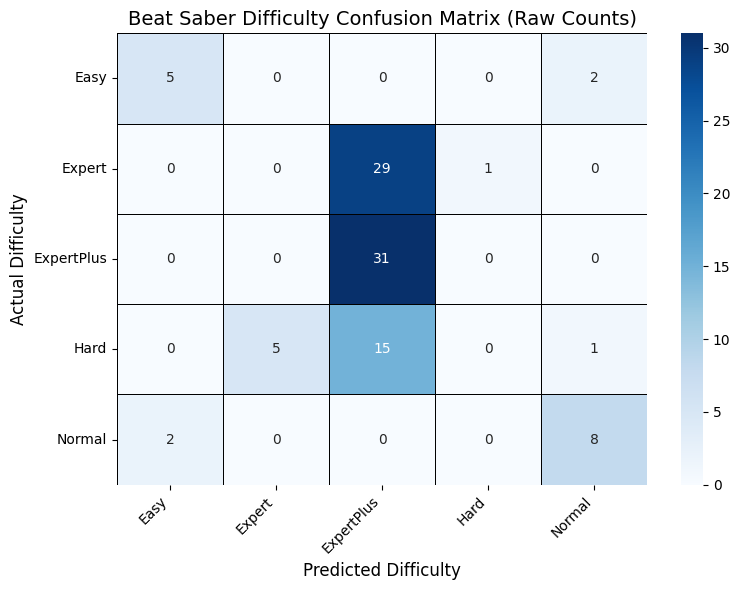

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

actual_np = Y_test_gpu.cpu().numpy()
predicted_np = predictions.cpu().numpy()

results_df = pd.DataFrame({
    'Actual_Code': actual_np,
    'Predicted_Code': predicted_np
})

label_map = {0: 'Easy', 1: 'Normal', 2: 'Hard', 3: 'Expert', 4: 'ExpertPlus'}

results_df['Actual_Label'] = results_df['Actual_Code'].map(label_map)
results_df['Predicted_Label'] = results_df['Predicted_Code'].map(label_map)

confusion_matrix = pd.crosstab(
    results_df['Actual_Label'], 
    results_df['Predicted_Label'], 
    rownames=['Actual'], 
    colnames=['Predicted']
)

print(confusion_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix,
    annot=True, 
    fmt='d',    
    cmap='Blues',
    cbar=True, 
    linewidths=.5,
    linecolor='black'
)

plt.title('Beat Saber Difficulty Confusion Matrix (Raw Counts)', fontsize=14)
plt.ylabel('Actual Difficulty', fontsize=12)
plt.xlabel('Predicted Difficulty', fontsize=12)
plt.xticks(rotation=45, ha='right') # x축 레이블 회전
plt.yticks(rotation=0)

plt.tight_layout() # 그래프 요소가 겹치지 않도록 조정
plt.show()